<a href="https://colab.research.google.com/github/Bhimsendabby/ImageColorization/blob/main/ImageColorizationUsingAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir /content/.kaggle

In [ ]:
!chmod 600 /content/kaggle.json

chmod: cannot access '/content/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d arnaud58/landscape-pictures

Dataset URL: https://www.kaggle.com/datasets/arnaud58/landscape-pictures
License(s): CC0-1.0
 99% 611M/620M [00:08<00:00, 117MB/s]
100% 620M/620M [00:09<00:00, 72.2MB/s]


In [ ]:
!kaggle datasets download -d ankit1743/skyview-an-aerial-landscape-dataset

Dataset URL: https://www.kaggle.com/datasets/ankit1743/skyview-an-aerial-landscape-dataset
License(s): CC0-1.0
 94% 145M/154M [00:02<00:00, 61.0MB/s]
100% 154M/154M [00:02<00:00, 59.5MB/s]


In [ ]:
!unzip landscape-pictures.zip -d /content/images

In [ ]:
# !unzip skyview-an-aerial-landscape-dataset.zip -d /content/newimages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as plt
import cv2
import os
import zipfile
import matplotlib.pyplot as plt
import os
import PIL
import keras
import tensorflow as tf
from keras import layers, models
import time
from IPython import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from keras.layers import Conv2D, UpSampling2D,LeakyReLU
from keras.models import Sequential
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave, imshow, imread
import shutil


#Set the image size
IMAGE_SIZE = 256

In [ ]:
TRAIN_ROOT_DIR = "/content/images"
DEST = "/content/train/images"

if not os.path.exists(DEST):
  os.makedirs(DEST)


  for img in os.listdir(TRAIN_ROOT_DIR):
    ORG = os.path.join(TRAIN_ROOT_DIR,img)

    try:
      imread(ORG)
      shutil.copy(ORG, DEST)
    except:
      print(f"Image {ORG} can not be used")

In [ ]:
TRAIN_ROOT_DIR = "/content/newimages/Aerial_Landscapes"
DEST = "/content/train/images"

if os.path.exists(DEST):

  for dir in os.listdir(TRAIN_ROOT_DIR):
    for img in os.listdir(os.path.join(TRAIN_ROOT_DIR,dir)):
      ORG = os.path.join(TRAIN_ROOT_DIR,dir,img)

      try:
        imread(ORG)
        shutil.copy(ORG, DEST)
      except:
        print(f"Image {ORG} can not be used")

In [ ]:
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   featurewise_center=True,
                                   vertical_flip=True,
                                   horizontal_flip=True,)

#Resize images, if needed
train_2 = train_datagen.flow_from_directory("/content/train",
                                          target_size=(256, 256),
                                          batch_size=3000,
                                          shuffle=True,
                                          class_mode=None)

Found 5119 images belonging to 1 classes.


In [ ]:
# Get a batch of images from the generator
images = train_2.next()

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


In [ ]:
len(os.listdir("/content/train/images"))

5119

In [ ]:
def plot_image(images):
  # Plot the first few images
  plt.figure(figsize=(10, 10))
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i])
      plt.axis("off")
  plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


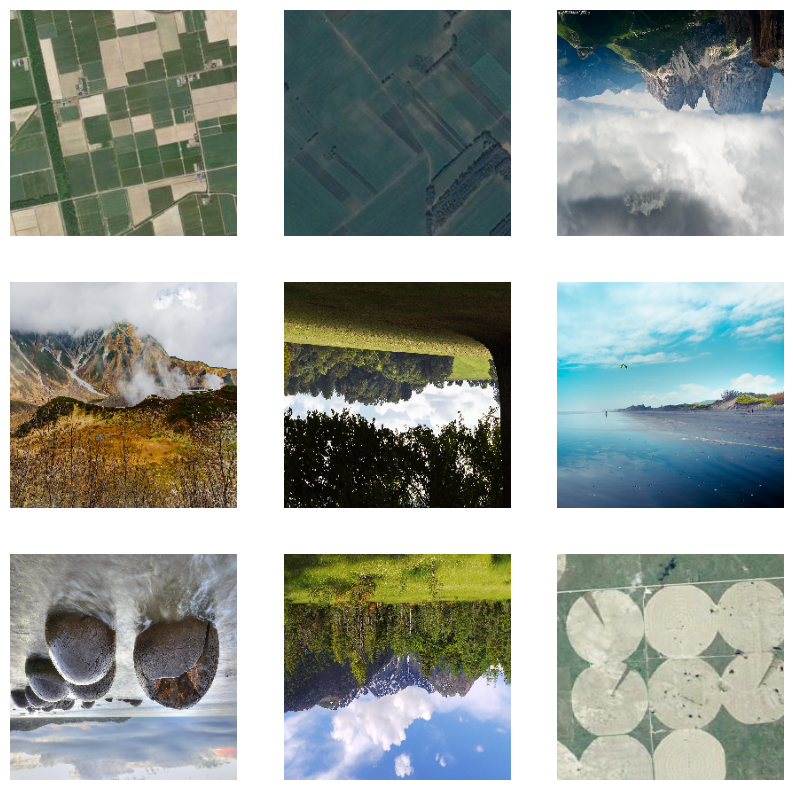

In [ ]:
plot_image(train_2[0])

In [ ]:
X =[]
y =[]


for img in train_2[0]:
  try:
    lab = rgb2lab(img)
    X.append(lab[:,:,0])
    y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128,
        #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
    print('error')

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


In [ ]:
X = np.array(X)
Y = np.array(y)

In [ ]:
X_train = X.reshape(X.shape+(1,))

In [ ]:
X_train.shape, Y.shape

((3000, 256, 256, 1), (3000, 256, 256, 2))

In [ ]:
# Define the Autoencoder model
def build_autoencoder(input_shape, latent_dim):

     # Encoder
    encoder_inputs = layers.Input(shape=input_shape)
    encoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_inputs)
    encoder = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
    encoder = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoder)
    encoder = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)
    encoder = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)
    encoder = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)

    # Latent Space
    latent_vector = layers.Flatten()(encoder)
    latent_vector = layers.Dense(latent_dim, activation='relu')(latent_vector)

    # Decoder
    decoder_inputs = layers.Dense(16 * 16 * 128, activation='relu')(latent_vector)
    decoder = layers.Reshape((16, 16, 128))(decoder_inputs)
    decoder = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(decoder)
    decoder = layers.UpSampling2D((2, 2))(decoder)
    decoder = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(decoder)
    decoder = layers.UpSampling2D((2, 2))(decoder)
    decoder = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(decoder)
    decoder = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(decoder)
    decoder = layers.UpSampling2D((2, 2))(decoder)

    decoder = layers.Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder)
    decoder_outputs = layers.UpSampling2D((2, 2))(decoder)

    # Define the autoencoder model
    autoencoder = models.Model(encoder_inputs, decoder_outputs)
    return autoencoder

In [ ]:
input_shape = (256, 256, 1)  # Example input shape (grayscale images)
latent_dim = 128  # Example latent dimension size
autoencoder = build_autoencoder(input_shape, latent_dim)
autoencoder.summary()

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Decoder
#Decoder
#Note: For the last layer we use tanh instead of Relu.
#This is because we are colorizing the image in this layer using 2 filters, A and B.
#A and B values range between -1 and 1 so tanh (or hyperbolic tangent) is used
#as it also has the range between -1 and 1.
#Other functions go from 0 to 1.
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       2

In [ ]:
model.fit(X_train,Y,validation_split=0.1, epochs=30, batch_size=32, steps_per_epoch=X_train.shape[0]//32, verbose=1)

1/1 [==============================] - 2s 2s/step


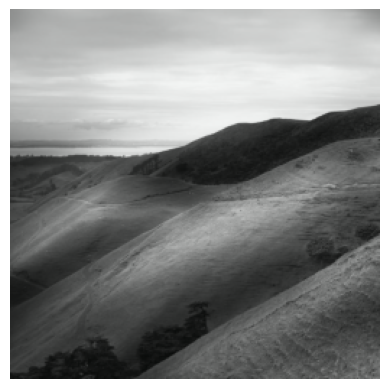

In [ ]:
img1_color=[]

img1=img_to_array(load_img('/content/00000000.jpg'))
img1 = resize(img1 ,(256,256))
img1_color.append(img1)

img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = model.predict(img1_color)
output1 = output1*128

result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]

plt.imshow(lab2rgb(result))
plt.axis('off')

plt.show()